This kernel contains **multyprocess implementation** of data loading and preprocessing for
[Clap it - Exploratory Data Analysis](https://www.kaggle.com/jandevel/clap-it-exploratory-data-analysis) kernel
It makes this operation several times faster.
Take it as example that can be applied to other kernels as well

# Introduction:
What is Medium? Medium is a dynamically developing international publishing platform for people to write, read and clap easily online. It is like the russian [habrahabr.ru](http://habrahabr.ru) just a little worse. We have two JSON files that contain published articles on Medium till 2018, March. There is number of claps to each article in the first file and there is no ones in the second file. Our goal is to predict the number of "claps" for articles in test. 
Let's start our EDA journey!

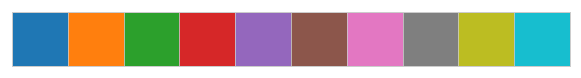

In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from scipy.sparse import csr_matrix, hstack
from scipy.stats import probplot
import pickle
import nltk, re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns 
import gc
import warnings
warnings.filterwarnings('ignore')
import time
import lightgbm as lgb

color = sns.color_palette()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.palplot(color)

#import os
#PATH = "../input"

In [2]:
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer)
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import (RidgeCV, Ridge)
from sklearn.model_selection import (GridSearchCV, 
                                     cross_val_score,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from scipy.sparse import (csr_matrix, hstack)

# 1. Data preprocessing
## 1.1. Supplementary functions

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

**New multiprocess stuff starts here: ====================================================== ** 

In [4]:
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm_notebook
     
def process_line(line):
    json_data = read_json_line(line)
    content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
    #content_no_html_tags = strip_tags(content)
    published = json_data['published']['$date']
    title = json_data['meta_tags']['title'].split('\u2013')[0].strip() #'Medium Terms of Service – Medium Policy – Medium'
    author = json_data['meta_tags']['author'].strip()
    domain = json_data['domain']
    url = json_data['url']
    reading_time = json_data['meta_tags']['twitter:data1']

    tags_str = []
    soup = BeautifulSoup(content, 'lxml')
    try:
        tag_block = soup.find('ul', class_='tags')
        tags = tag_block.find_all('a')
        for tag in tags:
            tags_str.append(tag.text.translate({ord(' '):None, ord('-'):None}))
        tags = ' '.join(tags_str)
    except Exception:
        tags = 'None'
    return content, published, title, author, domain, tags, url, reading_time
 
def extract_features(path_to_data):
    
    content_list = [] 
    published_list = [] 
    title_list = []
    author_list = []
    domain_list = []
    tags_list = []
    url_list = []
    reading_time_list = []

    with open(path_to_data, encoding='utf-8') as inp_json_file:
        num_cores = multiprocessing.cpu_count()
        results = Parallel(n_jobs=num_cores)(delayed(process_line)(line) for line in tqdm_notebook(inp_json_file))
    return zip(*results) #content_list, published_list, title_list, author_list, domain_list, tags_list, url_list

## 1.2. Data extraction

In [5]:
content_train, published_list, title_list, author_list, domain_list, tags_list, url_list, reading_time_list = extract_features('train.json')
train = pd.DataFrame()
#train['content'] = content_train
train['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
train['title'] = title_list
train['author'] = author_list
train['domain'] = domain_list
train['tags'] = tags_list
train['length'] = list(map(len, content_train))
train['url'] = url_list
train['reading_time'] = reading_time_list


In [6]:
train_target = pd.read_csv('train_log1p_recommends.csv', index_col='id')
y_train = train_target['log_recommends'].values

In [7]:
content_test, published_list, title_list, author_list, domain_list, tags_list, url_list, reading_time_list = extract_features('test.json')
test = pd.DataFrame()
#test['content'] = content_test
test['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
test['title'] = title_list
test['author'] = author_list
test['domain'] = domain_list
test['tags'] = tags_list
test['length'] = list(map(len, content_test))
test['url'] = url_list
test['reading_time'] = reading_time_list

del published_list, title_list, author_list, domain_list, tags_list, url_list, reading_time_list
gc.collect()

382

In [8]:
def get_contents(path_to_file):
    contents = list()
    with open(path_to_file, encoding='utf-8') as inp_json_file:
        for line in inp_json_file:
            json_data = read_json_line(line)
            content = json_data['content']  
            contents.append(content)
    return contents

**New mutiprocess stuff ends here: ====================================================== **    
Take into account that where is no train['content'] and test['content'] columns more,   
but only content_train and content_test listsaaa

## 1.3. Feature engineering

In [9]:
idx_split = len(train)
df_full = pd.concat([train, test])

df_full['dow'] = df_full['published'].apply(lambda x: x.dayofweek)
df_full['year'] = df_full['published'].apply(lambda x: x.year)
df_full['month'] = df_full['published'].apply(lambda x: x.month)
df_full['hour'] = df_full['published'].apply(lambda x: x.hour)
df_full['number_of_tags'] = df_full['tags'].apply(lambda x: len(x.split()))
df_full['reading_time'] = df_full['reading_time'].apply(lambda x: x.split()[0]).astype('int')

train = df_full.iloc[:idx_split, :]
test = df_full.iloc[idx_split:, :]

train['target'] = y_train
train.sort_values(by='published', inplace=True)
train.reset_index(drop=True, inplace=True)

print('TRAIN: {}'.format(train.shape))
print('TEST: {}'.format(test.shape))
del df_full
gc.collect()

TRAIN: (62313, 14)
TEST: (34645, 13)


0

The train data contains 62313 articles and the test one contains 34645.
Let us look at the data a little closer.

# 2. EDA
The five earliest articles on Medium:

In [10]:
train.head()

,published,title,author,domain,tags,length,url,reading_time,dow,year,month,hour,number_of_tags,target
0,1970-01-01 00:00:00.001,Saving Your Marriage By Watching Steamy Sex Ed...,Susan Bratton,medium.com,Lovemaking Sex SexPositions EarlyBird SexEdVideos,22062,http://personallifemedia.com/2017/01/saving-ma...,5,3,1970,1,0,5,1.09861
1,1970-01-01 00:00:00.001,やってよかった中学受験,Ryo Ooishi,medium.com,,17958,https://medium.com/@ooishi/%E3%82%84%E3%81%A3%...,11,3,1970,1,0,0,2.56495
2,1970-01-18 03:21:32.400,はてなブログに書いた今年の手帳のお話,なぞちゅう,medium.com,徒然日記 手帳 ブログ,18680,http://nazoblackrx.hatenablog.com/entry/2016/1...,5,6,1970,1,3,3,0.69315
3,1987-12-08 21:45:00.000,Internet Corporation LLC to Acquire Early Clue...,Internet Corporation LLC,medium.com,SocialMedia EarlyClues InternetCorporationLlc,30480,https://medium.com/the-internet-corporation/de...,8,1,1987,12,21,3,1.09861
4,2003-12-29 17:00:00.000,g sowtwaretrading botMoneyMoneyMakeGetting To ...,Mackenzie Oldridge,medium.com,Finance Trading,24725,http://www.investopedia.com/articles/optioninv...,9,0,2003,12,17,2,3.52636


In [11]:
test.head()

,published,title,author,domain,tags,length,url,reading_time,dow,year,month,hour,number_of_tags
0,2018-02-21 17:01:00.928,"For Night Owls, the Day Starts with a Nocturna...",HITRECORD,medium.com,MorningRoutines Hitrecord Podcast Night,31442,https://medium.com/on-mornings/nocturnalmornin...,10,2,2018,2,17,4
1,2017-12-07 15:56:00.967,Blockchain is Memory,Maria Bustillos,medium.com,Blockchain Technology History Network WordsTha...,23171,https://medium.com/wordsthatmatter/never-break...,5,3,2017,12,15,5
2,2018-02-08 17:33:27.816,ON MORNINGS Credits,HITRECORD,medium.com,Medium Hitrecord OnMornings,80606,https://medium.com/on-mornings/onmorningscredi...,4,3,2018,2,17,3
3,2018-02-09 18:04:12.262,Apple HomePod Review: Almost love,Lance Ulanoff,medium.com,Apple Homepod Technology Review Audio,30834,https://medium.com/@LanceUlanoff/apple-homepod...,10,4,2018,2,18,5
4,2017-10-02 23:08:00.000,Tips and tricks for Medium writers,Medium,blog.medium.com,Medium Help Tips,23565,https://blog.medium.com/tips-and-tricks-for-me...,4,0,2017,10,23,3


In [12]:
train_original = train.copy()
test_orininal = test.copy()

In [13]:
train = train_original
test = test_orininal

As we can see, first articles were published about 50 years ago. Great :)

In [14]:
def get_content_features(contents):
    content_lengths = list()
    h1_counts = list()
    h2_counts = list()
    h3_counts = list()
    img_counts = list()
    href_counts = list()
    
    for content in contents:
        content_stripped = strip_tags(content)
        content_length = len(content_stripped.split())
        content_lengths.append(content_length)
        h1_counts.append(content.count('<h1'))
        h2_counts.append(content.count('<h2'))
        h3_counts.append(content.count('<h3'))
        img_counts.append(content.count('<img'))
        href_counts.append(content.count('<href'))
        
    counts = np.hstack([np.array(h1_counts).reshape(-1, 1),
                    np.array(h2_counts).reshape(-1, 1),
                    np.array(h3_counts).reshape(-1, 1),
                    np.array(img_counts).reshape(-1, 1),
                    np.array(href_counts).reshape(-1, 1)])

    content_lengths = np.array(content_lengths)
    is_short = (content_lengths<1350).astype('int')
    is_medium = ((content_lengths>=1350) & (content_lengths<2700)).astype('int')
    is_long = ((content_lengths>=2700) & (content_lengths<6750)).astype('int')
    is_huge = (content_lengths>=6750).astype('int')
    
    length_types = np.hstack([is_short.reshape(-1, 1),
                              is_medium.reshape(-1, 1),
                              is_long.reshape(-1, 1),
                              is_huge.reshape(-1, 1) ])
    
    return counts, length_types

In [15]:
%%time
train_raw_contents = get_contents('train.json')

KeyboardInterrupt: 

In [16]:
%%time
test_raw_contents = get_contents('test.json')

KeyboardInterrupt: 

In [ ]:
counts_scaler = StandardScaler()

In [ ]:
%%time
train_counts, train_content_len = get_content_features(train_raw_contents)
train_counts_scaled = np.log1p(train_counts)

In [483]:
#train_cleaned_contents = [strip_tags(x) for x in train_raw_contents]

In [484]:
#test_cleaned_contents = [strip_tags(x) for x in test_raw_contents]

In [485]:
#train = train.assign(content = train_cleaned_contents)
#test = test.assign(content = test_cleaned_contents)

In [486]:
train_content_len.shape

(62313, 4)

In [487]:
type(train_content_len)

numpy.ndarray

In [488]:
train_content_len.T[0]

array([1, 0, 1, ..., 1, 0, 1])

In [489]:
pd.DataFrame(train_counts_scaled).describe()

,0,1,2,3,4
count,62313.000000,62313.000000,62313.000000,62313.000000,62313.0
mean,0.670199,0.200652,1.336665,2.019245,0.0
std,0.124016,0.338497,0.598708,0.585507,0.0
min,0.000000,0.000000,0.693147,1.098612,0.0
25%,0.693147,0.000000,0.693147,1.609438,0.0
50%,0.693147,0.000000,1.098612,1.945910,0.0
75%,0.693147,0.693147,1.791759,2.397895,0.0
max,0.693147,4.143135,5.043425,6.282267,0.0


In [ ]:
%%time
test_counts, test_content_len = get_content_features(test_raw_contents)
test_counts_scaled = np.log1p(test_counts)

In [ ]:
test_counts_scaled.shape

In [ ]:
train['h1_counts'] = train_counts_scaled.T[0]
train['h2_counts'] = train_counts_scaled.T[1]
train['h3_counts'] = train_counts_scaled.T[2]
train['img_counts'] = train_counts_scaled.T[3]
train['href_counts'] = train_counts_scaled.T[4]
train['is_content_short'] = train_content_len.T[0]
train['is_content_medium'] = train_content_len.T[1]
train['is_content_long'] = train_content_len.T[2]
train['is_content_huge'] = train_content_len.T[3]

In [ ]:
test['h1_counts'] = test_counts_scaled.T[0]
test['h2_counts'] = test_counts_scaled.T[1]
test['h3_counts'] = test_counts_scaled.T[2]
test['img_counts'] = test_counts_scaled.T[3]
test['href_counts'] = test_counts_scaled.T[4]
test['is_content_short'] = test_content_len.T[0]
test['is_content_medium'] = test_content_len.T[1]
test['is_content_long'] = test_content_len.T[2]
test['is_content_huge'] = test_content_len.T[3]

In [ ]:
train = train[train.year >= 2015]

In [ ]:
train_counts_scaled = train.loc[:, ['h1_counts', 'h2_counts', 'h3_counts', 'img_counts']]
train_content_len = train.loc[:, ['is_content_short', 'is_content_medium', 'is_content_long', 'is_content_huge']]
train_counts_scaled = train_counts_scaled.values
train_content_len = train_content_len.values

In [ ]:
test_counts_scaled = test.loc[:, ['h1_counts', 'h2_counts', 'h3_counts', 'img_counts']]
test_counts_scaled = test_counts_scaled.values

In [ ]:
class StemmingLemmatizingTokenizer(object):
    
    def __init__(self, stemmer=PorterStemmer, lemmatizer=WordNetLemmatizer):
        self.stemmer = stemmer()
        self.lemmatizer = lemmatizer()
        
    def __call__(self, doc):
        # strings of punctuation signs and digits
        from string import punctuation, digits
        # some other unicode chars i found in the content
        other_unicode_chars = '’’”“\u200b'
        chars_to_remove = ''.join((punctuation,
                                   digits,
                                   other_unicode_chars))
        # getting rid of punctuation signs and digits
        transtab = str.maketrans(chars_to_remove, ' '*len(chars_to_remove))
        # goiinf through all tokens with 3 or more chars
        # lemmatizing the verbs first, then stemming all words
        return [self.stemmer.stem(self.lemmatizer.lemmatize(token, pos='v')) 
                for token in word_tokenize(doc.translate(transtab)) 
                if len(token) >= 3]

In [ ]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS
temp = []
s = StemmingLemmatizingTokenizer()
for eggs in stop_words:
    token = s(eggs)
    if token:
        temp += token
stop_words = temp

In [ ]:
title_vectorizer = TfidfVectorizer(ngram_range=(2, 3), 
                                   tokenizer=StemmingLemmatizingTokenizer(),
                                   stop_words=stop_words,
                                   max_features=100000)
content_vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                                     tokenizer=StemmingLemmatizingTokenizer(),
                                     stop_words=stop_words,
                                     max_features=100000)
tag_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=2000)

In [500]:
#train_content_temp = list(train.content)
#test_content_temp = list(test.content)

In [501]:
#%%time
#Train_content_sparse = content_vectorizer.fit_transform(train_content_temp)
#Test_content_sparse = content_vectorizer.transform(test_content_temp)

Wall time: 47min 14s


In [ ]:
train_titles = list(train.title)
test_titles = list(test.title)

In [ ]:
%%time
Train_title_sparse = title_vectorizer.fit_transform(train_titles)
Test_title_sparse = title_vectorizer.transform(test_titles)

In [ ]:
Train_title_sparse, Test_title_sparse

In [ ]:
#%%time
#train_content_sparse = content_vectorizer.fit_transform((strip_tags(content) 
#                                                   for content in train_raw_contents))

In [ ]:
#%%time
#test_content_sparse = content_vectorizer.fit_transform((strip_tags(content) 
#                                                   for content in test_raw_contents))

In [ ]:
train_tags = list(train.tags)
test_tags = list(test.tags)

In [ ]:
train_tags_sparse = tag_vectorizer.fit_transform(train_tags) 
test_tags_sparse = tag_vectorizer.transform(test_tags)

In [ ]:
train_tags_sparse.shape, test_tags_sparse.shape

In [ ]:
train_times = train.loc[:, ['published', 'dow', 'year', 'month', 'hour']]
test_times = test.loc[:, ['published', 'dow', 'year', 'month', 'hour']]

In [ ]:
def add_time_features(df, X_sparse):
    morning = ((df.hour >= 7) & (df.hour <= 11)).astype('int')
    day = ((df.hour >= 12) & (df.hour <= 18)).astype('int')
    evening = ((df.hour >= 19) & (df.hour <= 23)).astype('int')
    night = ((df.hour >= 0) & (df.hour <= 6)).astype('int')
    
#    weekday = df['date'].apply(lambda ts: ts.weekday())
    is_monday = (df.dow == 0).astype('int')
    is_tuesday = (df.dow == 1).astype('int')
    is_wednesday = (df.dow == 2).astype('int')
    is_thursday = (df.dow == 3).astype('int')
    is_friday = (df.dow == 4).astype('int')
    is_weekend = (df.dow >= 5).astype('int')
    
    X = hstack([X_sparse,
                morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1),
                evening.values.reshape(-1, 1), 
                night.values.reshape(-1, 1),
                is_monday.values.reshape(-1, 1),
                is_tuesday.values.reshape(-1, 1),
                is_wednesday.values.reshape(-1, 1),
                is_thursday.values.reshape(-1, 1),
                is_friday.values.reshape(-1, 1),
                is_weekend.values.reshape(-1, 1)]).tocsr()
    return X

In [ ]:
train_data = add_time_features(train_times, Train_title_sparse)
test_data = add_time_features(test_times, Test_title_sparse)

In [ ]:
# create feature for title length
train['title_length'] = train.title.apply(lambda x : len(x.split()))
test['title_length'] = test.title.apply(lambda x : len(x.split()))

In [ ]:
# create new dataframes for length features
train_content_len = train.loc[:,['length']]
test_content_len = test.loc[:,['length']]

In [178]:
def get_content_features(df):
    
#    is_content_short = (df.length<1350).astype('int')
#    is_content_medium = ((df.length>=1350) & (df.length<2700)).astype('int')
#    is_content_long = ((df.length>=2700) & (df.length<6750)).astype('int')
#    is_content_huge = (df.length>=6750).astype('int')
    is_content_short = (df.length<30000).astype('int')
    is_content_medium = ((df.length>=30000) & (df.length<46000)).astype('int')
    is_content_long = ((df.length>=60000) & (df.length<80000)).astype('int')
    is_content_huge = (df.length>=80000).astype('int')
    length_types = np.hstack([is_content_short.values.reshape(-1, 1),
                              is_content_medium.values.reshape(-1, 1),
                              is_content_long.values.reshape(-1, 1),
                              is_content_huge.values.reshape(-1, 1)])    
    return length_types

In [181]:
train_content_len = get_content_features(train_content_len)
test_content_len = get_content_features(test_content_len)

In [182]:
train_content_len.shape, test_content_len.shape

((57125, 4), (34645, 4))

In [ ]:
train['title_length'].describe(percentiles = [0.1,0.25,0.5,0.75,0.9,0.95,0.99])

In [ ]:
train_title_len = train.loc[:,['title_length']]
test_title_len = test.loc[:,['title_length']]

In [ ]:
def get_title_length(df):
    is_title_short = (df.title_length <6).astype('int')
    is_title_medium = ((df.title_length>=6) & (df.title_length<11)).astype('int')
    is_title_long = ((df.title_length>=11) & (df.title_length<18)).astype('int')
    is_title_huge = (df.title_length>=20).astype('int')
    length_types = np.hstack([is_title_short.values.reshape(-1, 1),
                              is_title_medium.values.reshape(-1, 1),
                              is_title_long.values.reshape(-1, 1),
                              is_title_huge.values.reshape(-1, 1) ])    
    return length_types

In [ ]:
train_title_len = get_title_length(train_title_len)
test_title_len = get_title_length(test_title_len)

In [ ]:
train_title_len.shape, test_title_len.shape

In [ ]:
author_vectorizer = CountVectorizer(max_features=25000)
train_author = list(train.author)
test_author = list(test.author)
train_author_sparse = author_vectorizer.fit_transform(train_author)
test_author_sparse = author_vectorizer.transform(test_author)

In [ ]:
train_author_sparse.shape, test_author_sparse.shape

In [ ]:
domain_vectorizer = CountVectorizer(max_features=100)
train_domain = list(train.domain)
test_domain = list(test.domain)
train_domain_sparse = domain_vectorizer.fit_transform(train_domain)
test_domain_sparse = domain_vectorizer.transform(test_domain)

In [ ]:
train_domain_sparse.shape, test_domain_sparse.shape

In [ ]:
#train_month = pd.get_dummies(train['month'], columns = ['month'], prefix= 'month', sparse=True)
#test_month = pd.get_dummies(test['month'], columns = ['month'], prefix= 'month', sparse=True)

In [ ]:
#train_month_sparse = train_month.values
#test_month_sparse = test_month.values

In [ ]:
train_hour = pd.get_dummies(train['hour'], columns = ['hour'], prefix= 'hour', sparse=True)
test_hour = pd.get_dummies(test['hour'], columns = ['hour'], prefix= 'hour', sparse=True)

In [ ]:
train_hour_sparse = train_hour.values
test_hour_sparse = test_hour.values

In [ ]:
counts_scaler = StandardScaler()
#train_tag_count = list(train.number_of_tags)
#test_tag_count = list(test.number_of_tags)
train_tag_count_scaled = counts_scaler.fit_transform(np.array(train.number_of_tags).reshape(-1, 1))
test_tag_count_scaled = counts_scaler.transform(np.array(test.number_of_tags).reshape(-1, 1))

In [ ]:
train_readtime_scaled = np.array(np.log1p(train.reading_time)).reshape(-1, 1)
test_readtime_scaled = np.array(np.log1p(test.reading_time)).reshape(-1, 1)

In [ ]:
train_tag_count_scaled.shape, test_tag_count_scaled.shape

In [ ]:
type(test_tag_count_scaled)

In [535]:
print(train_data.shape),
print(train_tags_sparse.shape),
print(train_content_len.shape),
print(train_title_len.shape),
print(train_author_sparse.shape),
print(train_domain_sparse.shape),
print(train_counts_scaled.shape),
print(train_hour_sparse.shape),
#  train_month_sparse,
print(train_readtime_scaled.shape),
print(train_tag_count_scaled.shape),
print(Train_content_sparse.shape)

(57125, 100010)
(57125, 2000)
(57125, 4)
(57125, 4)
(57125, 25000)
(57125, 100)
(57125, 4)
(57125, 24)
(57125, 1)
(57125, 1)
(57125, 100000)


In [536]:
print(test_data.shape),
print(test_tags_sparse.shape),
print(test_content_len.shape),
print(test_title_len.shape),
print(test_author_sparse.shape),
print(test_domain_sparse.shape),
print(test_counts_scaled.shape),
print(test_hour_sparse.shape),
#print(test_month_sparse.shape),
print(test_readtime_scaled.shape),
print(test_tag_count_scaled.shape)
print(Test_content_sparse.shape)

(34645, 100010)
(34645, 2000)
(34645, 4)
(34645, 4)
(34645, 25000)
(34645, 100)
(34645, 4)
(34645, 24)
(34645, 1)
(34645, 1)
(34645, 100000)


In [537]:
train_data_final = hstack([train_data,
                           Train_content_sparse,
                           train_tags_sparse,
                           train_content_len,
                           train_title_len,
                           train_author_sparse,
                           train_domain_sparse,
                           train_counts_scaled,
                           train_hour_sparse,
#                           train_month_sparse,
                           train_readtime_scaled,
                           train_tag_count_scaled]).tocsr()

In [538]:
test_data_final = hstack([test_data,
                          Test_content_sparse,
                          test_tags_sparse,
                          test_content_len,
                          test_title_len,
                          test_author_sparse,
                          test_domain_sparse,
                          test_counts_scaled,
                          test_hour_sparse,
#                          test_month_sparse,
                          test_readtime_scaled,
                          test_tag_count_scaled]).tocsr()

In [539]:
train_data_final

<57125x227148 sparse matrix of type '<class 'numpy.float64'>'
	with 30436292 stored elements in Compressed Sparse Row format>

In [540]:
test_data_final

<34645x227148 sparse matrix of type '<class 'numpy.float64'>'
	with 17339695 stored elements in Compressed Sparse Row format>

In [541]:
train_target = train['target'].values

In [542]:
%%time
ridge = Ridge(random_state=17)
X_train, X_valid, y_train, y_valid = train_test_split(train_data_final, train_target, train_size=0.7, test_size=0.3, random_state=17)
ridge.fit(X_train, np.log1p(y_train));
ridge_pred = np.expm1(ridge.predict(X_valid))
#plt.hist(y_test, bins=30, alpha=.5, color='red',
#         label='true values', range=(0,10));
#plt.hist(ridge_pred, bins=30, alpha=.5, color='green',
#         label='predicted values', range=(0,10));
#plt.legend();
valid_mae = mean_absolute_error(y_valid, ridge_pred)
print(valid_mae, np.expm1(valid_mae))

1.1516384148176801 2.163371580997529
Wall time: 31.3 s


In [404]:
%%time
alphas = (0.005, 0.01, 0.5, 0.25, 0.1, 1)
ridgeCV = RidgeCV(alphas=alphas, cv=5, gcv_mode='auto',
                scoring='neg_mean_absolute_error')
#ridge.fit(train_data_final, np.log1p(train_target));
#print('alpha: ', ridge.alpha_) # i'm just curious what it would be
ridgeCV.fit(X_train, np.log1p(y_train));
ridgecv_valid_pred = np.expm1(ridgeCV.predict(X_valid))
print('alpha: ', ridgeCV.alpha_)
valid_mae = mean_absolute_error(y_valid, ridgecv_valid_pred)
print(valid_mae, np.expm1(valid_mae))

alpha:  1.0
1.1219583553434582 2.0708621578337603
Wall time: 2min 12s


In [543]:
lgb_x_train_part = lgb.Dataset(X_train.astype(np.float32), 
                           label=np.log1p(y_train))

In [ ]:
lgb_x_valid = lgb.Dataset(X_valid.astype(np.float32), 
                      label=np.log1p(y_valid))

In [ ]:
param = {'num_leaves': 255, 
         'objective': 'mean_absolute_error',
         'metric': 'mae'}

In [ ]:
num_round = 200
bst_lgb = lgb.train(param, lgb_x_train_part, num_round, 
                    valid_sets=[lgb_x_valid], early_stopping_rounds=20)

In [ ]:
lgb_pred = np.expm1(bst_lgb.predict(X_valid.astype(np.float32), 
                                    num_iteration=bst_lgb.best_iteration))

In [ ]:
valid_mae = mean_absolute_error(y_valid, lgb_pred)
print(valid_mae, np.expm1(valid_mae))

In [ ]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.hist(lgb_pred, bins=30, alpha=.5, color='blue', label='Lgbm', range=(0,10));
plt.legend();

In [ ]:
mean_absolute_error(y_valid, .4 * lgb_pred + .6 * ridge_pred)

In [413]:
%%time
ridge.fit(train_data_final, np.log1p(train_target));

Wall time: 4.16 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [414]:
ridge_test_pred = np.expm1(ridge.predict(test_data_final))

In [415]:
%%time
ridgeCV.fit(train_data_final, np.log1p(train_target));

Wall time: 4min 16s


RidgeCV(alphas=array([0.005, 0.01 , 0.5  , 0.25 , 0.1  , 1.   ]), cv=5,
    fit_intercept=True, gcv_mode='auto', normalize=False,
    scoring='neg_mean_absolute_error', store_cv_values=False)

In [416]:
ridgeCV_test_pred = np.expm1(ridgeCV.predict(test_data_final))

In [417]:
lgb_x_train = lgb.Dataset(train_data_final.astype(np.float32),
                          label=np.log1p(train_target))

In [418]:
num_round = 60
bst_lgb = lgb.train(param, lgb_x_train, num_round)

In [419]:
lgb_test_pred = np.expm1(bst_lgb.predict(test_data_final.astype(np.float32)))

In [420]:
mix_pred_ridge_lgb = .4 * lgb_test_pred + .6 * ridge_test_pred

In [421]:
mix_pred_ridgeCV_lgb = .4 * lgb_test_pred + .6 * ridgeCV_test_pred

In [422]:
def write_submission_file(prediction, filename,
                          path_to_sample='sample_submission.csv'):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [423]:
write_submission_file(mix_pred_ridge_lgb, 'submission_ridge_lgb.csv')
write_submission_file(mix_pred_ridgeCV_lgb, 'submission_ridgeCV_lgb.csv')

In [424]:
mean_test_target = 4.33328
mix_pred_ridge_lgb_modif = mix_pred_ridge_lgb + mean_test_target - train_target.mean()
mix_pred_ridgeCV_lgb_modif = mix_pred_ridgeCV_lgb + mean_test_target - train_target.mean()

In [425]:
#Only ridge without lgb 
mean_test_target = 4.33328
mix_pred_ridge_modif = ridge_test_pred + mean_test_target - train_target.mean()
mix_pred_ridgeCV_modif = ridgeCV_test_pred + mean_test_target - train_target.mean()

In [426]:
write_submission_file(mix_pred_ridge_lgb_modif, 'submission_ridge_lgb_modi.csv')
write_submission_file(mix_pred_ridgeCV_lgb_modif, 'submission_ridgeCV_lgb_modi.csv')

In [212]:
write_submission_file(mix_pred_ridge_modif, 'submission_ridge_modi.csv')
write_submission_file(mix_pred_ridgeCV_modif, 'submission_ridgeCV_modi.csv')

In [88]:
mix_pred_ridgeCV_lgb_37 = .3 * lgb_test_pred + .7 * ridgeCV_test_pred
mix_pred_ridgeCV_lgb_modif_37 = mix_pred_ridgeCV_lgb_37 + mean_test_target - train_target.mean()
write_submission_file(mix_pred_ridgeCV_lgb_modif_37, 'submission_ridgeCV_lgb_modi_37.csv')